In [1]:
import pandas as pd
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import seaborn as sns

In [2]:
df = pd.read_csv('c:/data/creditcard/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


c:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '분류\n (0: 정상거래, 1: 사기거래)')

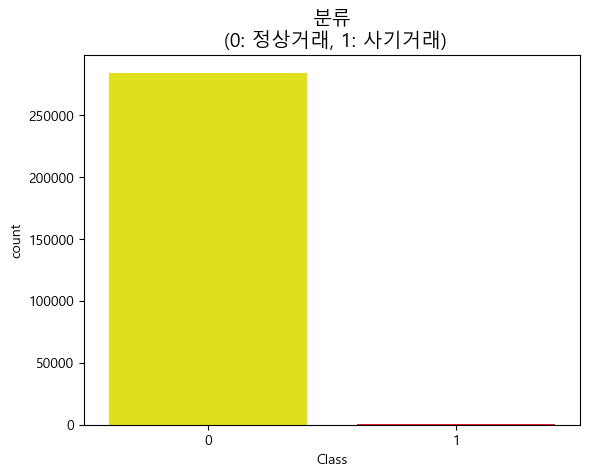

In [3]:
#데이터 불균형 확인
colors = ['yellow', 'red']
sns.countplot('Class', data=df, palette=colors)
plt.title('분류\n (0: 정상거래, 1: 사기거래)', fontsize=14)

In [4]:
print('사기거래')
print(df.Amount[df.Class == 1].describe())
print()
print('정상거래')
print(df.Amount[df.Class == 0].describe())

사기거래
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

정상거래
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


In [5]:
train_cols = df.columns[1:30]
X = df[train_cols]
y = df['Class']

In [6]:
#언더샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample, columns=train_cols)
y_samp = pd.DataFrame(data=y_sample, columns=['Class'])
df2 = pd.concat([X_samp, y_samp], axis=1)
df2['Class'].value_counts()

0    492
1    492
Name: Class, dtype: int64

In [7]:
X = X_samp
y = y_samp

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=10)

In [9]:
#분류 모델 구현 함수
from keras.models import Sequential
from keras.layers import Dense, Dropout
import numpy as np
np.random.seed(123)
def make_model(input_number, hidden_layers, output_number):
    # 모델 초기화
    model = Sequential(name='model1')
    model.add(Dense(hidden_layers[0], activation='relu', 
                    input_shape=(input_number, ), name='hidden-1'))
    model.add(Dense(hidden_layers[1], activation='relu', name='hidden-2'))
    model.add(Dense(hidden_layers[2], activation='relu', name='hidden-3'))
    # 드롭아웃 계층
    model.add(Dropout(0.2, name='Dropout'))
    # 출력층
    model.add(Dense(output_number, activation='sigmoid', name='Output'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
model = make_model(len(X_train.columns), [128, 64, 32], 1)

In [11]:
model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden-1 (Dense)            (None, 128)               3840      
                                                                 
 hidden-2 (Dense)            (None, 64)                8256      
                                                                 
 hidden-3 (Dense)            (None, 32)                2080      
                                                                 
 Dropout (Dropout)           (None, 32)                0         
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 14,209
Trainable params: 14,209
Non-trainable params: 0
_________________________________________________________________


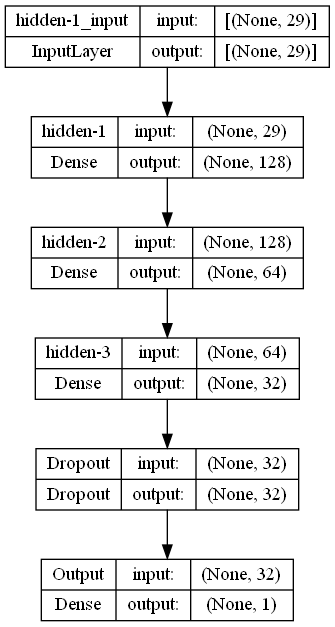

In [12]:
from keras.utils import plot_model  
plot_model(model,show_shapes=True)

In [14]:
from datetime import datetime  
import tensorflow as tf  
logdir="c:/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")  
logdir

'c:/logs/20230417-114019'

In [15]:
#모델 학습
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)  
hist = model.fit(X_train, y_train, epochs=70, 
                 callbacks=[tensorboard_callback])

Epoch 1/70
25/25 [==============================] - 1s 4ms/step - loss: 0.2757 - accuracy: 0.6506
Epoch 2/70
25/25 [==============================] - 0s 3ms/step - loss: 0.1475 - accuracy: 0.8437
Epoch 3/70
25/25 [==============================] - 0s 5ms/step - loss: 0.2276 - accuracy: 0.7332
Epoch 4/70
25/25 [==============================] - 0s 4ms/step - loss: 0.1751 - accuracy: 0.8183
Epoch 5/70
25/25 [==============================] - 0s 4ms/step - loss: 0.1127 - accuracy: 0.8793
Epoch 6/70
25/25 [==============================] - 0s 4ms/step - loss: 0.1036 - accuracy: 0.8907
Epoch 7/70
25/25 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.9250
Epoch 8/70
25/25 [==============================] - 0s 4ms/step - loss: 0.1075 - accuracy: 0.8869
Epoch 9/70
25/25 [==============================] - 0s 4ms/step - loss: 0.0820 - accuracy: 0.9161
Epoch 10/70
25/25 [==============================] - 0s 3ms/step - loss: 0.0882 - accuracy: 0.8996
Epoch 11/70
25/25 [

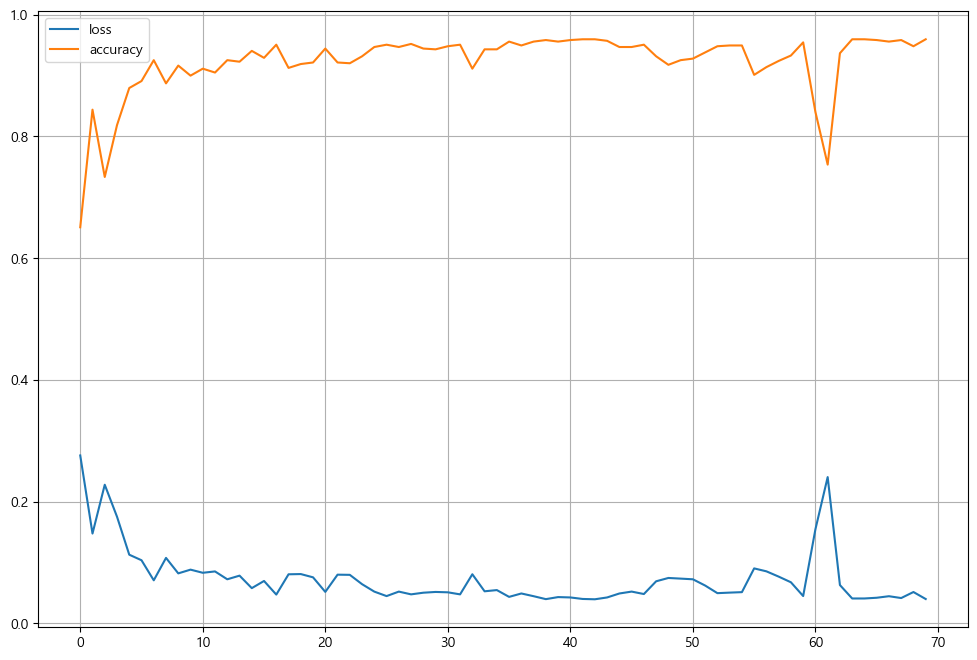

In [16]:
#모델 학습 과정 표시
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.legend(['loss', 'accuracy'])
plt.grid()
plt.show()

In [17]:
#모델 평가
scores = model.evaluate(X_train, y_train, verbose=1)
print(scores)
print("학습용 %s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - accuracy: 0.9644
[0.03449399024248123, 0.9644218683242798]
학습용 accuracy: 96.44%


In [18]:
scores = model.evaluate(X_test, y_test, verbose=1)
print(scores)
print("검증용 %s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

7/7 [==============================] - 0s 2ms/step - loss: 0.0860 - accuracy: 0.9137
[0.08600636571645737, 0.913705587387085]
검증용 accuracy: 91.37%


In [36]:
pred = model.predict(X)
print(pred[-10:-5])
print(np.round(pred[-10:-5]))

31/31 [==============================] - 0s 2ms/step
[[9.9999964e-01]
 [1.0000000e+00]
 [8.5003707e-38]
 [4.6627738e-02]
 [1.0000000e+00]]
[[1.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [33]:
#모델 저장
model.save('c:/data/creditcard/model.h5')